## Load model

In [1]:
from keras.applications import VGG16

#Set image size
img_rows = 224
img_cols = 224

#Load model
model = VGG16(weights = 'imagenet', include_top = False, input_shape = (img_rows, img_cols, 3))

#Freeze layers
for layer in model.layers:
    layer.trainable = False
    
#Print layers
for(i, layer) in enumerate(model.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


## Modify model 

In [2]:
def addTopModel(bottom_model, num_classes, D = 256):
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization

num_classes = 10
FC_Head = addTopModel(model, num_classes)
modelnew = Model(inputs = model.input, outputs = FC_Head)

print(modelnew.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Get training and test data

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_data = "/Users/Bryan Tan/Desktop/Project/Dataset/Train/Image"
test_data = "/Users/Bryan Tan/Desktop/Project/Dataset/Test/Image"

#Data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_batchsize = 16
test_batchsize = 10

train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size = (img_rows, img_cols),
    batch_size = train_batchsize,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size = (img_rows, img_cols),
    batch_size = test_batchsize,
    class_mode = 'categorical',
    shuffle = False
)

Found 100 images belonging to 10 classes.
Found 30 images belonging to 10 classes.


## Train model

In [5]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "face_VGG.h5",
    monitor = "val_loss",
    mode = "min",
    save_best_only = True,
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = "val_loss",
    min_delta = 0,
    patience = 3,
    verbose = 1,
    restore_best_weights = True
)

callbacks = [earlystop, checkpoint]

modelnew.compile(loss = 'categorical_crossentropy',
                optimizer = RMSprop(learning_rate=0.001),
                metrics = ['accuracy'])

nb_train_samples = 100
nb_test_samples = 30
epochs = 5
batch_size = 16

history = modelnew.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = test_generator,
    validation_steps = nb_test_samples // batch_size
)

Epoch 1/5
6/6 [==============================] - ETA: 0s - loss: 13.7433 - accuracy: 0.1071
Epoch 1: val_loss improved from inf to 6.00726, saving model to face_VGG.h5
6/6 [==============================] - 51s 8s/step - loss: 13.7433 - accuracy: 0.1071 - val_loss: 6.0073 - val_accuracy: 0.3000
Epoch 2/5
6/6 [==============================] - ETA: 0s - loss: 9.4710 - accuracy: 0.1190
Epoch 2: val_loss improved from 6.00726 to 4.77131, saving model to face_VGG.h5
6/6 [==============================] - 35s 6s/step - loss: 9.4710 - accuracy: 0.1190 - val_loss: 4.7713 - val_accuracy: 0.0000e+00
Epoch 3/5
6/6 [==============================] - ETA: 0s - loss: 5.1398 - accuracy: 0.1548
Epoch 3: val_loss improved from 4.77131 to 3.53496, saving model to face_VGG.h5
6/6 [==============================] - 38s 6s/step - loss: 5.1398 - accuracy: 0.1548 - val_loss: 3.5350 - val_accuracy: 0.1000
Epoch 4/5
6/6 [==============================] - ETA: 0s - loss: 3.3962 - accuracy: 0.2262
Epoch 4: val_

## Model evaluation

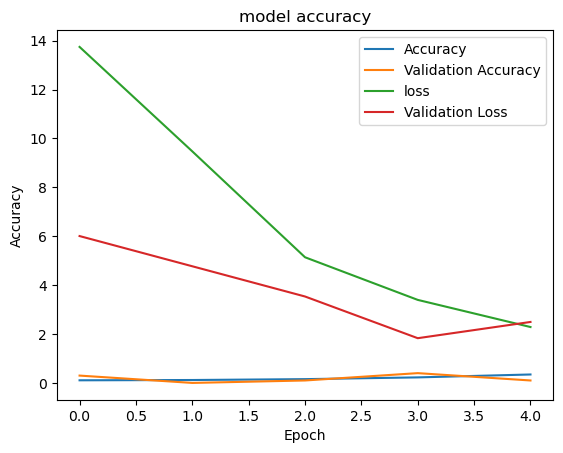

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

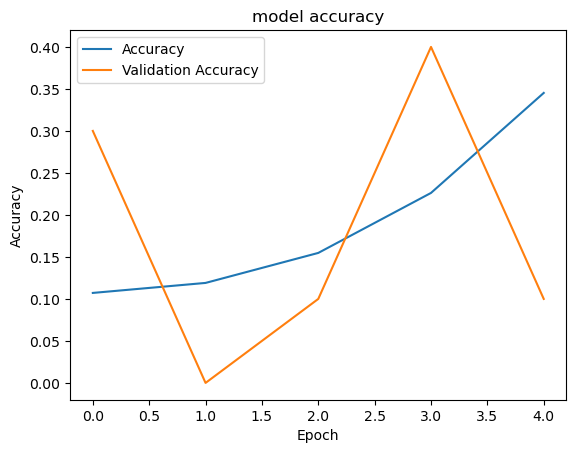

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

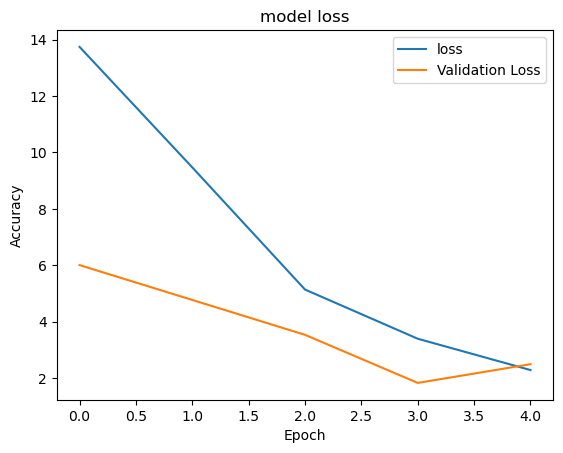

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()